<h1 align="center">Lab 2:  Sexism Identification in Twitter</h1>
<h2 align="center">Session 3. Transformers: Fine-tuning for multi-label classification
<h3 style="display:block; margin-top:5px;" align="center">Natural Language and Information Retrieval</h3>
<h3 style="display:block; margin-top:5px;" align="center">Degree in Data Science</h3>
<h3 style="display:block; margin-top:5px;" align="center">2024-2025</h3>    
<h3 style="display:block; margin-top:5px;" align="center">ETSInf. Universitat Politècnica de València</h3>
<br>

### Put your names here

- Kacper Multan
- Filip Polacik

In [1]:
 !pip install transformers --upgrade
 !pip  install datasets accelerate
 !pip install PyEvALL
 !pip install scikit-learn
 !pip install peft
 #!pip install jupyter --upgrade
 #!pip install ipywidgets --upgrade

## Many libraries

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import  AutoTokenizer, AutoModelForSequenceClassification,  Trainer, TrainingArguments,  EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import random
import os
import pandas as pd
import sys
import tempfile
import time

#Importing the required modules to use the ICM measure

from pyevall.evaluation import PyEvALLEvaluation
from pyevall.metrics.metricfactory import MetricFactory
from pyevall.reports.reports import PyEvALLReport
from pyevall.utils.utils import PyEvALLUtils

from functools import partial

In [3]:
# IF YOU USE GOOGLE COLAB -> COLAB=True
COLAB = True

In [4]:
if COLAB is True:
  from google.colab import drive
  drive.mount('/content/drive')
  base_path = "/content/drive/MyDrive/LNR/"
else:
  base_path = "../"

Mounted at /content/drive


## Import readerEXIST2025 library

In [5]:
library_path = os.path.join(base_path, "Lab2-S1")
sys.path.append(library_path)
!cp /content/drive/MyDrive/Colab\ Notebooks/readerEXIST2025.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/EXIST_2025_Dataset_V0.2/EXIST2025_training.json /content
!cp /content/drive/MyDrive/Colab\ Notebooks/EXIST_2025_Dataset_V0.2/EXIST2025_dev.json /content

from readerEXIST2025 import EXISTReader

In [19]:
file_train = os.path.join("", "EXIST2025_training.json")
file_dev = os.path.join("", "EXIST2025_dev.json")

reader_train = EXISTReader(file_train)
reader_dev = EXISTReader(file_dev)

EnTrainTask3, EnDevTask3 = reader_train.get(lang="EN", subtask="3"), reader_dev.get(lang="EN", subtask="3")
SpTrainTask3, SpDevTask3 = reader_train.get(lang="ES", subtask="3"), reader_dev.get(lang="ES", subtask="3")

# Wrapper to compute ICM measure

In [8]:
def ICMWrapper(pred, labels, multi=False,ids=None):
    test = PyEvALLEvaluation()
    metrics=[MetricFactory.ICM.value]
    params= dict()
    fillLabel=None
    if multi:
        params[PyEvALLUtils.PARAM_REPORT]="embedded"
        hierarchy={"True":['IDEOLOGICAL-INEQUALITY', 'STEREOTYPING-DOMINANCE', 'MISOGYNY-NON-SEXUAL-VIOLENCE', 'OBJECTIFICATION', 'SEXUAL-VIOLENCE'],
        "False":[]}
        params[PyEvALLUtils.PARAM_HIERARCHY]=hierarchy
        fillLabel = lambda x: ["False"] if len(x)== 0 else x
    else:
        params[PyEvALLUtils.PARAM_REPORT]="simple"
        fillLabel = lambda x: str(x)


    truth_name, predict_name=None, None
    if ids is None:
        ids=list(range(len(labels)))

    with tempfile.NamedTemporaryFile(mode='w', delete=False, encoding='utf-8') as truth:
        truth_name=truth.name
        truth_df=pd.DataFrame({'test_case': ['EXIST2025']*len(labels),
                        'id': [str(x) for x in ids],
                        'value': [fillLabel(x) for x in labels]})
        if multi==True:
            truth_df=truth_df.astype('object')
        truth.write(truth_df.to_json(orient="records"))

    with  tempfile.NamedTemporaryFile(mode='w', delete=False) as predict:
        predict_name=predict.name
        predict_df=pd.DataFrame({'test_case': ['EXIST2025']*len(pred),
                        'id': [str(x) for x in ids],
                        'value': [fillLabel(x) for x in pred]})
        if multi==True:
            predict_df=predict_df.astype('object')
        predict.write(predict_df.to_json(orient="records"))

    report = test.evaluate(predict_name, truth_name, metrics, **params)
    os.unlink(truth_name)
    os.unlink(predict_name)

    icm = None
    if 'metrics' in report.report:
        if 'ICM' in report.report["metrics"]: icm=float(report.report["metrics"]['ICM']["results"]["average_per_test_case"])
    return icm



## Set the seed

In [9]:
def set_seed(seed=1234):
    """
    Sets the seed to make everything deterministic, for reproducibility of experiments
    Parameters:
    seed: the number to set the seed to
    Return: None
    """
    # Random seed
    random.seed(seed)
    # Numpy seed
    np.random.seed(seed)
    # Torch seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    # os seed
    os.environ['PYTHONHASHSEED'] = str(seed)

## Dataset class

In [22]:
class SexismDatasetMulti(Dataset):
    def __init__(self, texts, labels, ids, tokenizer, max_len=128, pad="max_length", trunc=True,rt='pt'):
        self.texts = texts.tolist()
        self.labels = labels
        self.ids = ids
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad = pad
        self.trunc = trunc
        self.rt = rt


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,padding=self.pad, truncation=self.trunc,
            return_tensors=self.rt
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float),
            'id': torch.tensor(self.ids[idx], dtype=torch.long)}

# Metrics for subtask 3

In [11]:
def compute_metrics_3(pred, lencoder):
    labels = pred.label_ids
    #preds = pred.predictions.argmax(-1)
    preds = torch.sigmoid(torch.tensor(pred.predictions)).numpy()
    preds_binary = (preds >= 0.5).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds_binary, average=None, zero_division=0
    )
    acc = accuracy_score(labels, preds_binary)
    icm= ICMWrapper(lencoder.inverse_transform(preds_binary), lencoder.inverse_transform(labels), multi=True)
    # Macro averages
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    metrics = {}
    metrics.update({
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'ICM': icm
    })
    return metrics

# Pipeline

In [50]:
def sexism_classification_pipeline_task3(trainInfo, devInfo, testInfo=None, model_name='roberta-base', nlabels=5, ptype="multi_label_classification", **args):
    # Model and Tokenizer
    labelEnc= MultiLabelBinarizer()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=nlabels,
        problem_type=ptype)

    train_dataset = SexismDatasetMulti(trainInfo[1], labelEnc.fit_transform(trainInfo[2]),[int(x) for x in trainInfo[0]], tokenizer )
    val_dataset = SexismDatasetMulti(devInfo[1], labelEnc.transform(devInfo[2]), [int(x) for x in devInfo[0]], tokenizer)

    # Training Arguments
    training_args = TrainingArguments(
        report_to="none", # alt: "wandb", "tensorboard" "comet_ml" "mlflow" "clearml"
        output_dir= args.get('output_dir', './results'),
        num_train_epochs= args.get('num_train_epochs', 5),
        learning_rate=args.get('learning_rate', 5e-5),
        per_device_train_batch_size=args.get('per_device_train_batch_size', 16),
        per_device_eval_batch_size=args.get('per_device_eval_batch_size', 16),
        warmup_steps=args.get('warmup_steps', 500),
        weight_decay=args.get('weight_decay',0.01),
        logging_dir=args.get('logging_dir', './logs'),
        logging_steps=args.get('logging_steps', 10),
        eval_strategy=args.get('eval_strategy','epoch'),
        save_strategy=args.get('save_strategy', "epoch"),
        save_total_limit=args.get('save_total_limit', 1),
        load_best_model_at_end=args.get('load_best_model_at_end', True),
        metric_for_best_model=args.get('metric_for_best_model',"ICM")
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics = partial(compute_metrics_3, lencoder=labelEnc),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=args.get("early_stopping_patience",3))]
    )

    # Fine-tune the model
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()
    print("Validation Results:", eval_results)

    if testInfo is not None:
      # Prepare test dataset for prediction
      test_dataset = SexismDatasetMulti(testInfo[1], [[0,0,0,0,0]] * len(testInfo[1]),  [int(x) for x in testInfo[0]],   tokenizer)

      # Predict test set labels
      predictions = trainer.predict(test_dataset)
      #predicted_labels = np.argmax(predictions.predictions, axis=1)
      predicted_probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()
      predicted_labels = (predicted_probs >= 0.5).astype(int)

      # Create submission DataFrame
      submission_df = pd.DataFrame({
          'id': testInfo[0],
          'label': labelEnc.inverse_transform(predicted_labels),
          "test_case": ["EXIST2025"]*len(predicted_labels)

      })
      submission_df.to_csv('sexism_predictions_task3.csv', index=False)
      print("Prediction TASK3 completed. Results saved to sexism_predictions_task2.csv")
      return model, submission_df
    return model, eval_results

# LoRA pipeline

In [44]:
from peft import get_peft_model, LoraConfig, TaskType

def sexism_classification_pipeline_task3_lora(trainInfo, devInfo, testInfo=None, model_name='roberta-base', nlabels=5, ptype="multi_label_classification", **args):
    labelEnc = MultiLabelBinarizer()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=nlabels,
        problem_type=ptype
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=args.get('lora_r', 8),
        lora_alpha=args.get('lora_alpha', 16),
        lora_dropout=args.get('lora_dropout', 0.01),
        target_modules=["query", "value", "key", "output.dense"],
        bias="lora_only",
        modules_to_save=["classifier"]
    )

    model = get_peft_model(base_model, peft_config)

    train_dataset = SexismDatasetMulti(trainInfo[1], labelEnc.fit_transform(trainInfo[2]), [int(x) for x in trainInfo[0]], tokenizer)
    val_dataset = SexismDatasetMulti(devInfo[1], labelEnc.transform(devInfo[2]), [int(x) for x in devInfo[0]], tokenizer)

    training_args = TrainingArguments(
        report_to="none",
        output_dir=args.get('output_dir', './results'),
        num_train_epochs=args.get('num_train_epochs', 5),
        learning_rate=args.get('learning_rate', 5e-4),
        per_device_train_batch_size=args.get('per_device_train_batch_size', 16),
        per_device_eval_batch_size=args.get('per_device_eval_batch_size', 16),
        warmup_steps=args.get('warmup_steps', 500),
        weight_decay=args.get('weight_decay', 0.01),
        logging_dir=args.get('logging_dir', './logs'),
        logging_steps=args.get('logging_steps', 10),
        eval_strategy=args.get('eval_strategy', 'epoch'),
        save_strategy=args.get('save_strategy', "epoch"),
        save_total_limit=args.get('save_total_limit', 1),
        load_best_model_at_end=args.get('load_best_model_at_end', True),
        metric_for_best_model=args.get('metric_for_best_model', "ICM")
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=partial(compute_metrics_3, lencoder=labelEnc),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=args.get("early_stopping_patience", 3))],
        data_collator=None
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print("Validation Results:", eval_results)

    if testInfo is not None:
        test_dataset = SexismDatasetMulti(testInfo[1], [[0, 0, 0, 0, 0]] * len(testInfo[1]), [int(x) for x in testInfo[0]], tokenizer)
        predictions = trainer.predict(test_dataset)
        predicted_probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()
        predicted_labels = (predicted_probs >= 0.5).astype(int)

        submission_df = pd.DataFrame({
            'id': testInfo[0],
            'label': labelEnc.inverse_transform(predicted_labels),
            'test_case': ['EXIST2025'] * len(predicted_labels)
        })

        submission_df.to_csv('sexism_predictions_task3_lora.csv', index=False)
        print("Prediction TASK3 with LoRA completed. Results saved to sexism_predictions_task3_lora.csv")
        return model, submission_df

    return model, eval_results

# Experimentation

In [15]:
set_seed()

## Do it in English

In [51]:
set_seed()
params = dict()
params["num_train_epochs"] = 7
bert_en_normal_model, bert_en_normal_results = sexism_classification_pipeline_task3(EnTrainTask3, EnDevTask3, model_name="bert-base-uncased", **params)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.644200,0.647153,0.592954,0.793043,0.674650,0.013203
2,0.571400,0.601968,0.755350,0.575161,0.632836,-0.972108
3,0.542000,0.586524,0.708918,0.677836,0.686959,-0.549724
4,0.482400,0.589507,0.742172,0.655202,0.689311,-0.307321


2025-04-15 21:26:11,153 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:26:11,253 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:27:15,484 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:27:15,593 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:28:24,987 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:28:25,049 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:30:11,952 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:30:12,066 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method


2025-04-15 21:30:27,397 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:30:27,459 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.647153377532959, 'eval_precision_macro': 0.5929538369189942, 'eval_recall_macro': 0.7930431427346388, 'eval_f1_macro': 0.6746497784087705, 'eval_ICM': 0.013202583262698997, 'eval_runtime': 2.5939, 'eval_samples_per_second': 130.306, 'eval_steps_per_second': 2.313, 'epoch': 4.0}


In [52]:
set_seed()
params = dict()
params["num_train_epochs"] = 7
roberta_en_normal_model, roberta_en_normal_results = sexism_classification_pipeline_task3(EnTrainTask3, EnDevTask3, model_name="roberta-base", **params)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.650900,0.643109,0.415684,0.515897,0.446245,-0.640598
2,0.570800,0.584075,0.766863,0.591533,0.644971,-0.674001
3,0.521100,0.567615,0.740682,0.664022,0.694988,-0.627229
4,0.497200,0.597680,0.705224,0.737547,0.710477,0.349490
5,0.402200,0.603364,0.706226,0.740894,0.722428,0.136834
6,0.306500,0.671696,0.715450,0.729055,0.719878,0.105343
7,0.204500,0.706581,0.721969,0.679566,0.698780,0.030792


2025-04-15 21:31:15,774 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:31:15,870 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:33:12,714 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:33:12,877 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:34:29,987 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:34:30,050 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:36:48,270 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:36:48,332 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:38:07,500 - pyevall.evaluation - INFO -   

2025-04-15 21:42:30,426 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:42:30,496 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.5976800322532654, 'eval_precision_macro': 0.7052237494152073, 'eval_recall_macro': 0.7375471498604826, 'eval_f1_macro': 0.7104765890797007, 'eval_ICM': 0.3494895637933883, 'eval_runtime': 2.4086, 'eval_samples_per_second': 140.332, 'eval_steps_per_second': 2.491, 'epoch': 7.0}


In [40]:
set_seed()
params = dict()
params["lora_r"] = 8
params["lora_alpha"] = 16
params["lora_dropout"] = 0.1
params["num_train_epochs"] = 7
bert_en_lora_model, bert_en_lora_results = sexism_classification_pipeline_task3_lora(EnTrainTask3, EnDevTask3, model_name="bert-base-uncased", **params)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.655800,0.664362,0.489895,0.424207,0.362378,-1.012844
2,0.600900,0.623442,0.688576,0.569894,0.578125,-0.334696
3,0.582000,0.612376,0.701295,0.646978,0.667885,-0.801702
4,0.549900,0.575634,0.705305,0.723413,0.709848,0.215091
5,0.502800,0.567311,0.720784,0.686350,0.700560,-0.515976
6,0.475800,0.575245,0.750442,0.661069,0.698917,-0.663250
7,0.416300,0.594721,0.741977,0.662094,0.696582,-0.708562


2025-04-15 21:05:12,717 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:05:12,866 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:05:54,676 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:05:54,909 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:06:35,316 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:06:35,381 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:07:15,761 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:07:15,828 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:07:55,195 - pyevall.evaluation - INFO -   

2025-04-15 21:09:18,656 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:09:18,715 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.5728671550750732, 'eval_precision_macro': 0.7053304334756699, 'eval_recall_macro': 0.7164276627721142, 'eval_f1_macro': 0.7060813597423564, 'eval_ICM': 0.18630012344930805, 'eval_runtime': 2.8282, 'eval_samples_per_second': 119.509, 'eval_steps_per_second': 7.779, 'epoch': 7.0}


In [45]:
set_seed()
params = dict()
params["lora_r"] = 8
params["lora_alpha"] = 16
params["lora_dropout"] = 0.1
params["num_train_epochs"] = 7
roberta_en_lora_model, roberta_en_lora_results = sexism_classification_pipeline_task3_lora(EnTrainTask3, EnDevTask3, model_name="roberta-base", **params)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.660900,0.654315,0.422040,0.483077,0.422399,-0.764694
2,0.576900,0.590251,0.761199,0.589971,0.639523,-0.555241
3,0.544900,0.607061,0.748974,0.568718,0.611386,-1.041671
4,0.546300,0.571836,0.695173,0.750210,0.713834,0.338233
5,0.492900,0.557287,0.730419,0.706999,0.717271,-0.257078
6,0.464300,0.594765,0.732220,0.693953,0.708463,-0.133520
7,0.407100,0.614818,0.727459,0.681105,0.701936,-0.135519


2025-04-15 21:10:27,372 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:10:27,477 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:11:05,823 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:11:05,919 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:11:44,249 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:11:44,350 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:12:25,329 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:12:25,388 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:13:03,841 - pyevall.evaluation - INFO -   

2025-04-15 21:14:23,781 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:14:23,848 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.5748803019523621, 'eval_precision_macro': 0.701961452577717, 'eval_recall_macro': 0.7502264324843239, 'eval_f1_macro': 0.7201334394897998, 'eval_ICM': 0.3129179483634631, 'eval_runtime': 2.6963, 'eval_samples_per_second': 125.359, 'eval_steps_per_second': 8.159, 'epoch': 7.0}


## Do it in Spanish

In [53]:
set_seed()
params = dict()
params["num_train_epochs"] = 7
bert_es_normal_model, bert_es_normal_results = sexism_classification_pipeline_task3(EnTrainTask3, EnDevTask3, model_name="dccuchile/bert-base-spanish-wwm-uncased", **params)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.655300,0.650889,0.420465,0.456819,0.428820,-0.787776
2,0.604800,0.623462,0.678300,0.640337,0.647081,-0.150657
3,0.595200,0.631429,0.726367,0.538194,0.594650,-0.849332
4,0.547800,0.632286,0.667409,0.738899,0.691606,0.169938
5,0.423500,0.655454,0.694994,0.648737,0.666456,-0.294567
6,0.313600,0.746195,0.735258,0.651772,0.673287,-0.125859
7,0.192800,0.769249,0.699582,0.640811,0.663029,-0.246506


2025-04-15 21:43:19,098 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:43:19,158 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:44:24,796 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:44:24,858 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:46:07,475 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:46:07,580 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:47:39,121 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:47:39,187 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:49:05,260 - pyevall.evaluation - INFO -   

2025-04-15 21:52:22,398 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:52:22,469 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.6322862505912781, 'eval_precision_macro': 0.6674088522768875, 'eval_recall_macro': 0.7388992265000491, 'eval_f1_macro': 0.6916055740756913, 'eval_ICM': 0.16993791343886866, 'eval_runtime': 2.463, 'eval_samples_per_second': 137.229, 'eval_steps_per_second': 2.436, 'epoch': 7.0}


In [54]:
set_seed()
params = dict()
params["num_train_epochs"] = 7
roberta_es_normal_model, roberta_es_normal_results = sexism_classification_pipeline_task3(EnTrainTask3, EnDevTask3, model_name="PlanTL-GOB-ES/roberta-base-bne", **params)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.645700,0.634656,0.542247,0.560841,0.518355,-0.466486
2,0.608100,0.630720,0.771862,0.470485,0.503220,-1.333011
3,0.544600,0.626905,0.692641,0.649488,0.659707,-0.569422
4,0.429900,0.666371,0.671696,0.709795,0.673695,-0.022698
5,0.277500,0.733312,0.701799,0.653766,0.675719,-0.270930
6,0.127600,0.845511,0.693059,0.657054,0.669582,-0.176712
7,0.049600,0.914809,0.694149,0.638204,0.661910,-0.410744


2025-04-15 21:53:12,408 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:53:12,466 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:55:01,112 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:55:01,174 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:56:12,519 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:56:12,583 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:57:59,212 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 21:57:59,275 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 21:59:33,330 - pyevall.evaluation - INFO -   

2025-04-15 22:02:46,798 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:02:46,862 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.6663705706596375, 'eval_precision_macro': 0.6716957502291422, 'eval_recall_macro': 0.709794857739953, 'eval_f1_macro': 0.673694993183668, 'eval_ICM': -0.022697809902034734, 'eval_runtime': 2.4939, 'eval_samples_per_second': 135.531, 'eval_steps_per_second': 2.406, 'epoch': 7.0}


In [59]:
set_seed()
params = dict()
params["lora_r"] = 8
params["lora_alpha"] = 16
params["lora_dropout"] = 0.1
params["num_train_epochs"] = 7
bert_es_lora_model, bert_es_lora_results = sexism_classification_pipeline_task3_lora(EnTrainTask3, EnDevTask3, model_name="dccuchile/bert-base-spanish-wwm-uncased", **params)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.660100,0.667400,0.398569,0.433598,0.375546,-0.972291
2,0.633400,0.649231,0.616299,0.483224,0.455717,-0.694866
3,0.634000,0.634237,0.640235,0.641332,0.633443,-0.306423
4,0.588000,0.620257,0.688296,0.666499,0.661059,-0.042555
5,0.575600,0.594907,0.680565,0.749659,0.710212,0.201765
6,0.537600,0.612154,0.715877,0.665699,0.676403,-0.006645
7,0.480300,0.600665,0.710384,0.690859,0.698284,-0.192581


2025-04-15 22:08:22,233 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:08:22,333 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:09:01,436 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:09:01,498 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:09:40,653 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:09:40,716 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:10:19,855 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:10:19,920 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:10:58,986 - pyevall.evaluation - INFO -   

2025-04-15 22:12:20,867 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:12:20,967 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.5920096635818481, 'eval_precision_macro': 0.6881982584738702, 'eval_recall_macro': 0.7386722714228751, 'eval_f1_macro': 0.709713701376738, 'eval_ICM': 0.16853732697347593, 'eval_runtime': 2.861, 'eval_samples_per_second': 118.139, 'eval_steps_per_second': 7.69, 'epoch': 7.0}


In [58]:
set_seed()
params = dict()
params["lora_r"] = 8
params["lora_alpha"] = 16
params["lora_dropout"] = 0.1
params["num_train_epochs"] = 7
roberta_es_lora_model, roberta_es_lora_results = sexism_classification_pipeline_task3_lora(EnTrainTask3, EnDevTask3, model_name="PlanTL-GOB-ES/roberta-base-bne", **params)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Precision Macro,Recall Macro,F1 Macro,Icm
1,0.650500,0.643718,0.596785,0.528955,0.456078,-0.614663
2,0.616500,0.641748,0.738417,0.476903,0.489622,-0.952057
3,0.612400,0.640955,0.682983,0.588411,0.610033,-1.718106
4,0.560100,0.616469,0.742958,0.633897,0.640199,-0.017659
5,0.487700,0.599194,0.694998,0.710462,0.701733,0.029039
6,0.366100,0.721376,0.721442,0.620702,0.653685,-0.297765
7,0.208000,0.800966,0.701047,0.626934,0.659763,-0.548552


2025-04-15 22:03:48,183 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:03:48,290 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:04:26,045 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:04:26,139 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:05:03,895 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:05:03,955 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:05:41,803 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:05:41,867 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-15 22:06:20,377 - pyevall.evaluation - INFO -   

2025-04-15 22:07:41,214 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM']
2025-04-15 22:07:41,313 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
Validation Results: {'eval_loss': 0.606982946395874, 'eval_precision_macro': 0.7017458299727416, 'eval_recall_macro': 0.6948828351296383, 'eval_f1_macro': 0.6964711914504839, 'eval_ICM': -0.06009268361174214, 'eval_runtime': 2.9261, 'eval_samples_per_second': 115.51, 'eval_steps_per_second': 7.518, 'epoch': 7.0}


# Show Results

In [60]:
results = {
    'English': {
        'Fine-tuning': {
            'BERT': bert_en_normal_results,
            'RoBERTa': roberta_en_normal_results
        },
        'LoRA': {
            'BERT': bert_en_lora_results,
            'RoBERTa': roberta_en_lora_results
        }
    },
    'Spanish': {
        'Fine-tuning': {
            'BERT': bert_es_normal_results,
            'RoBERTa': roberta_es_normal_results
        },
        'LoRA': {
            'BERT': bert_es_lora_results,
            'RoBERTa': roberta_es_lora_results
        }
    }
}

def print_results():
    print("English")
    print("Fine-tuning")
    print(f"\tsubtask3: ICM:{results['English']['Fine-tuning']['BERT']['eval_ICM']:.4f} macro-f1:{results['English']['Fine-tuning']['BERT']['eval_f1_macro']:.4f}")
    print(f"\tsubtask3: ICM:{results['English']['Fine-tuning']['RoBERTa']['eval_ICM']:.4f} macro-f1:{results['English']['Fine-tuning']['RoBERTa']['eval_f1_macro']:.4f}")
    print("LoRA")
    print(f"\tsubtask3: ICM:{results['English']['LoRA']['BERT']['eval_ICM']:.4f} macro-f1:{results['English']['LoRA']['BERT']['eval_f1_macro']:.4f}")
    print(f"\tsubtask3: ICM:{results['English']['LoRA']['RoBERTa']['eval_ICM']:.4f} macro-f1:{results['English']['LoRA']['RoBERTa']['eval_f1_macro']:.4f}")
    print("Spanish")
    print("Fine-tuning")
    print(f"\tsubtask3: ICM:{results['Spanish']['Fine-tuning']['BERT']['eval_ICM']:.4f} macro-f1:{results['Spanish']['Fine-tuning']['BERT']['eval_f1_macro']:.4f}")
    print(f"\tsubtask3: ICM:{results['Spanish']['Fine-tuning']['RoBERTa']['eval_ICM']:.4f} macro-f1:{results['Spanish']['Fine-tuning']['RoBERTa']['eval_f1_macro']:.4f}")
    print("LoRA")
    print(f"\tsubtask3: ICM:{results['Spanish']['LoRA']['BERT']['eval_ICM']:.4f} macro-f1:{results['Spanish']['LoRA']['BERT']['eval_f1_macro']:.4f}")
    print(f"\tsubtask3: ICM:{results['Spanish']['LoRA']['RoBERTa']['eval_ICM']:.4f} macro-f1:{results['Spanish']['LoRA']['RoBERTa']['eval_f1_macro']:.4f}")

print_results()

English
Fine-tuning
	subtask3: ICM:0.0132 macro-f1:0.6746 (38.91 per epoch)
	subtask3: ICM:0.3495 macro-f1:0.7105 (20.65 per epoch)
LoRA
	subtask3: ICM:0.1863 macro-f1:0.7061 (24.24 per epoch)
	subtask3: ICM:0.3129 macro-f1:0.7201 (32.36 per epoch)
Spanish
Fine-tuning
	subtask3: ICM:0.1699 macro-f1:0.6916 (21.11 per epoch)
	subtask3: ICM:-0.0227 macro-f1:0.6737 (21.38 per epoch)
LoRA
	subtask3: ICM:0.1685 macro-f1:0.7097 (24.52 per epoch)
	subtask3: ICM:-0.0601 macro-f1:0.6965 (25.08 per epoch)


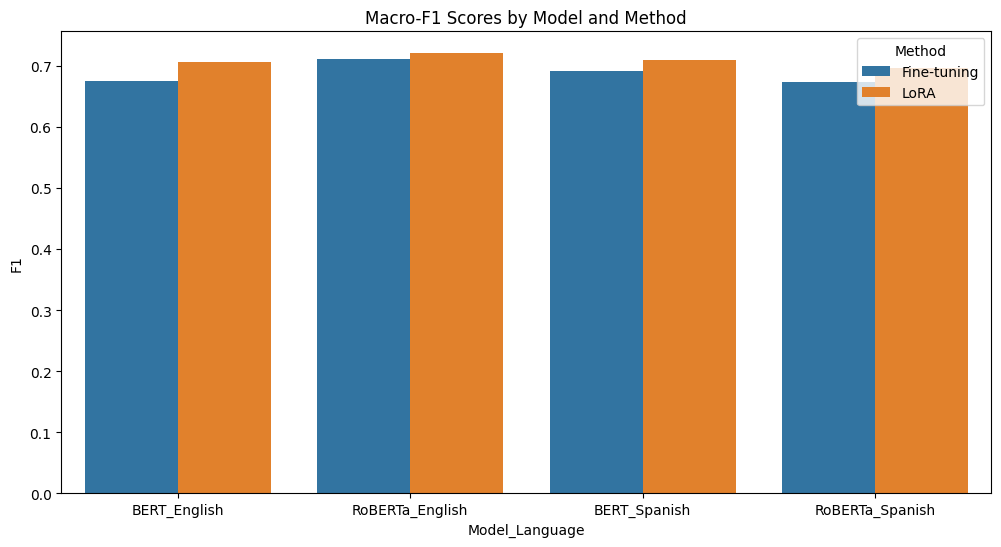

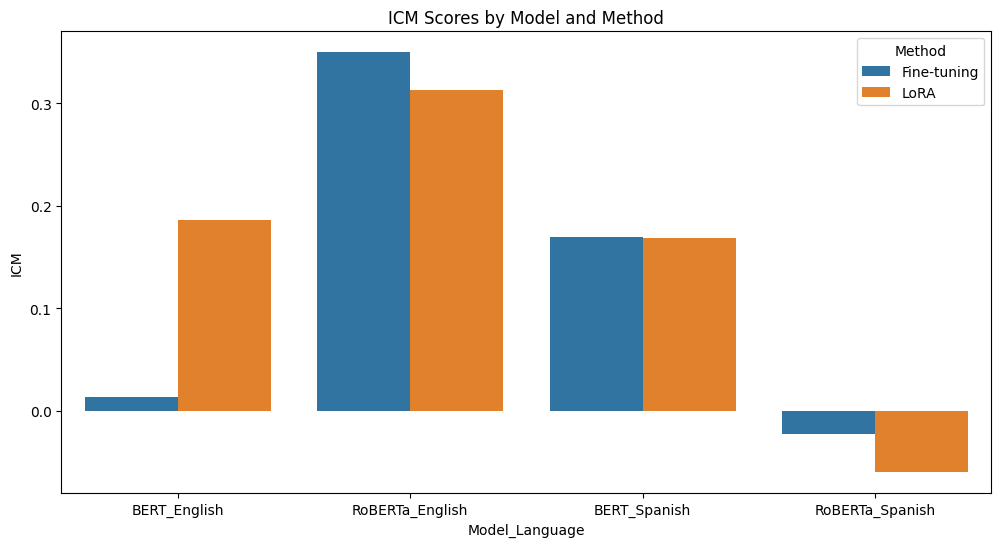

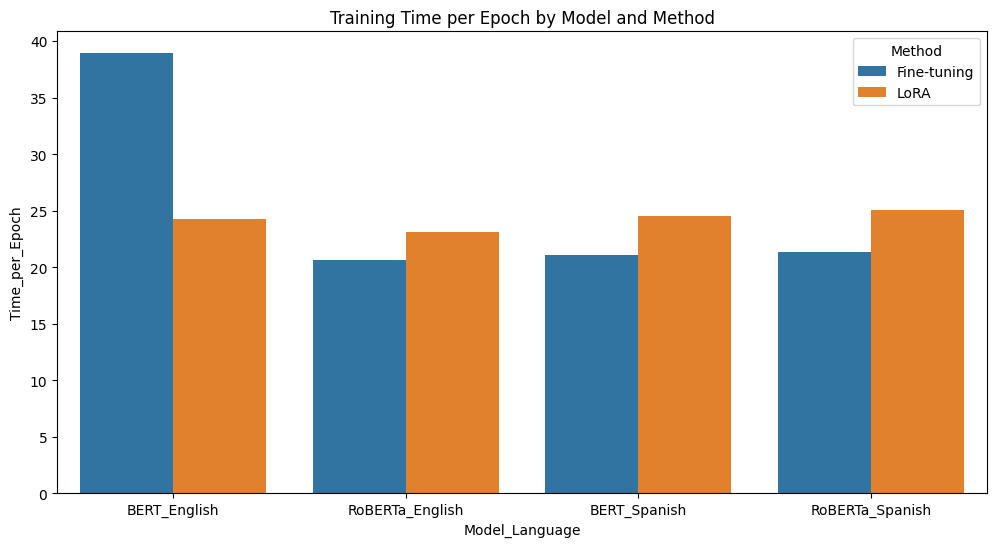

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results():
    data = []
    for lang in ['English', 'Spanish']:
        for method in ['Fine-tuning', 'LoRA']:
            for model in ['BERT', 'RoBERTa']:
                icm = results[lang][method][model]['eval_ICM']
                f1 = results[lang][method][model]['eval_f1_macro']
                time_per_epoch = results[lang][method][model]['eval_runtime'] / results[lang][method][model]['epoch'] * 60
                data.append([lang, method, model, icm, f1, time_per_epoch])

    df = pd.DataFrame(data, columns=['Language', 'Method', 'Model', 'ICM', 'F1', 'Time_per_Epoch'])
    df['Model_Language'] = df['Model'] + '_' + df['Language']
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model_Language', y='F1', hue='Method', data=df)
    plt.title('Macro-F1 Scores by Model and Method')
    plt.savefig('f1_scores.png')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model_Language', y='ICM', hue='Method', data=df)
    plt.title('ICM Scores by Model and Method')
    plt.savefig('icm_scores.png')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model_Language', y='Time_per_Epoch', hue='Method', data=df)
    plt.title('Training Time per Epoch by Model and Method')
    plt.savefig('training_time.png')

plot_results()

In [62]:
def create_results_table():
    data = []
    for lang in ['English', 'Spanish']:
        for method in ['Fine-tuning', 'LoRA']:
            for model in ['BERT', 'RoBERTa']:
                icm = results[lang][method][model]['eval_ICM']
                f1 = results[lang][method][model]['eval_f1_macro']
                time_per_epoch = results[lang][method][model]['eval_runtime'] / results[lang][method][model]['epoch'] * 60
                data.append([lang, method, model, f"{icm:.4f}", f"{f1:.4f}", f"{time_per_epoch:.2f}"])

    df = pd.DataFrame(data, columns=['Language', 'Method', 'Model', 'ICM', 'Macro-F1', 'Time/Epoch'])
    print(df.to_markdown(index=False))

create_results_table()

| Language   | Method      | Model   |     ICM |   Macro-F1 |   Time/Epoch |
|:-----------|:------------|:--------|--------:|-----------:|-------------:|
| English    | Fine-tuning | BERT    |  0.0132 |     0.6746 |        38.91 |
| English    | Fine-tuning | RoBERTa |  0.3495 |     0.7105 |        20.65 |
| English    | LoRA        | BERT    |  0.1863 |     0.7061 |        24.24 |
| English    | LoRA        | RoBERTa |  0.3129 |     0.7201 |        23.11 |
| Spanish    | Fine-tuning | BERT    |  0.1699 |     0.6916 |        21.11 |
| Spanish    | Fine-tuning | RoBERTa | -0.0227 |     0.6737 |        21.38 |
| Spanish    | LoRA        | BERT    |  0.1685 |     0.7097 |        24.52 |
| Spanish    | LoRA        | RoBERTa | -0.0601 |     0.6965 |        25.08 |
